<a href="https://colab.research.google.com/github/anshudaur/TensorFlowProjects/blob/master/Convolution_model_Application_OxfordFlowerDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.0 - TensorFlow model

In the previous assignment, you built helper functions using numpy to understand the mechanics behind convolutional neural networks. Most practical applications of deep learning today are built using programming frameworks, which have many built-in functions you can simply call. 

As usual, we will start by loading in the packages. 

In [2]:
pip install tensorflow-datasets

In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
import tensorflow_datasets.public_api as tfds

%matplotlib inline
np.random.seed(1)

Run the next cell to load the "SIGNS" dataset you are going to use.

In [26]:
import tensorflow as tf
import tensorflow_datasets as tfds

# tfds works in both Eager and Graph modes
#tf.compat.v1.enable_eager_execution()

# See available datasets
print(tfds.list_builders())

# Construct a tf.data.Dataset 
SPLIT_WEIGHTS = (6, 2, 2)
splits = tfds.Split.ALL.subsplit(weighted=SPLIT_WEIGHTS)
test_dataset,validation_dataset,train_dataset  = tfds.load(name="oxford_flowers102", split=list(splits) , 
                                                           shuffle_files=True,
                                                        download=True, as_supervised=True,
                                                        decoders={'image': tfds.decode.SkipDecoding()})

print(train_dataset)

['abstract_reasoning', 'aeslc', 'aflw2k3d', 'amazon_us_reviews', 'bair_robot_pushing_small', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'clevr', 'cmaterdb', 'cnn_dailymail', 'coco', 'coco2014', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'curated_breast_imaging_ddsm', 'cycle_gan', 'deep_weeds', 'definite_pronoun_resolution', 'diabetic_retinopathy_detection', 'downsampled_imagenet', 'dsprites', 'dtd', 'dummy_dataset_shared_generator', 'dummy_mnist', 'emnist', 'eurosat', 'fashion_mnist', 'flores', 'food101', 'gap', 'gigaword', 'glue', 'groove', 'higgs', 'horses_or_humans', 'image_label_folder', 'imagenet2012', 'imagenet2012_corrupted', 'imagenet_resized', 'imdb_reviews', 'iris', 'kitti', 'kmnist', 'lfw', 'lm1b', 'lsun', 'malaria', 'mnist'

In [23]:

def format_example(image, label):      
    image_decoded = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    # Normalize the pixel values
    image = image / 255.0
    # Resize the image
    image = tf.image.resize(image, (64, 64))
    return image, label

train = train_dataset.map(format_example)
validation = validation_dataset.map(format_example)
test = test_dataset.map(format_example)
print(train,test,validation)

<DatasetV1Adapter shapes: ((64, 64, 3), ()), types: (tf.float32, tf.int64)> <DatasetV1Adapter shapes: ((64, 64, 3), ()), types: (tf.float32, tf.int64)> <DatasetV1Adapter shapes: ((64, 64, 3), ()), types: (tf.float32, tf.int64)>


In [0]:
def augment_data(image, label):
  print("Augment data called!")
  image = tf.image.central_crop(image,central_fraction=0.7)
  print(image.shape)
  image = tf.image.random_crop(image,size=[32, 32, 3])
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
  image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
  image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
  # Make sure the image is still in [0, 1]
  image = tf.clip_by_value(image, 0.0, 1.0)
  # Add more augmentation of your choice
  return image, label

train = train.map(augment_data)
print(train.output_shapes)

Augment data called!
(46, 46, 3)
(TensorShape([Dimension(32), Dimension(32), Dimension(3)]), TensorShape([]))


(64, 64, 3)


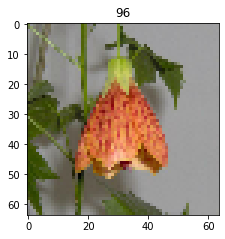

In [13]:
import matplotlib.pyplot as plt
import numpy

plt.figure(figsize=(12,12)) 

for batch in tfds.as_numpy(train):
  image, label = batch[0], batch[1]
  print(image.shape)
  plt.subplot(3, 3, 9)
  plt.imshow(image)
  plt.title(label)
  plt.grid(False)
  # We need to break the loop else the outer loop
  # will loop over all the batches in the training set
  break